### What is Heart Rate Variability?
Heart Rate Variability (HRV) is a measure of the variation in time intervals between consecutive heartbeats. Several formulas can be used to calculate HRV, including time-domain and frequency-domain methods. Common time-domain methods include SDNN, RMSSD, and SDSD, while frequency-domain methods include LF, HF, and LF/HF ratio.

SDNN (Standard Deviation of NN intervals) represents the overall variability in heart rate over a period, while SDSD (Standard Deviation of Successive Differences) specifically measures the variability between consecutive heartbeats. Essentially, SDNN captures both short-term and long-term fluctuations, while SDSD primarily focuses on short-term, beat-to-beat variability.

### Current Goal -> Strictly Analyze Baseline Data from Mothers

### Importing Necessary Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [20]:
bangle_data = pd.read_csv("../HRV106M/HRV106M_Finger_Baseline/bangle.csv")
bangle_data.head()

,timestamp_ms,value
0,1729020509805,4606
1,1729020509827,4606
2,1729020509847,4606
3,1729020509869,4606
4,1729020509891,4606


### Normalizing Timestamps and Plotting Raw Data

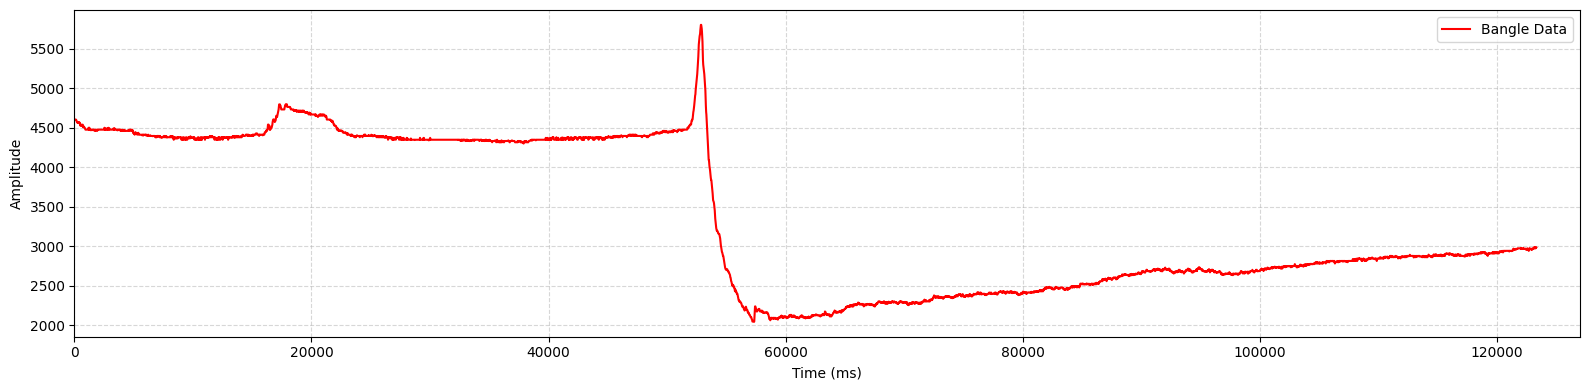

In [21]:
timestamps = bangle_data["timestamp_ms"].to_numpy()
ppg_raw = bangle_data["value"].to_numpy()

' Normalizing timestamp (ms), such that it starts from 0 ms'
t0 = bangle_data["timestamp_ms"].iloc[0]
timestamps = timestamps - t0

plt.figure(figsize=(16, 4))
plt.plot(timestamps, ppg_raw, c='r', label="Bangle Data")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=0, right=127000)
plt.tight_layout()
plt.show()

### Filtering With Old Method and Plotting Filtered Data

Estimated PPG sampling rate: 40.7 Hz


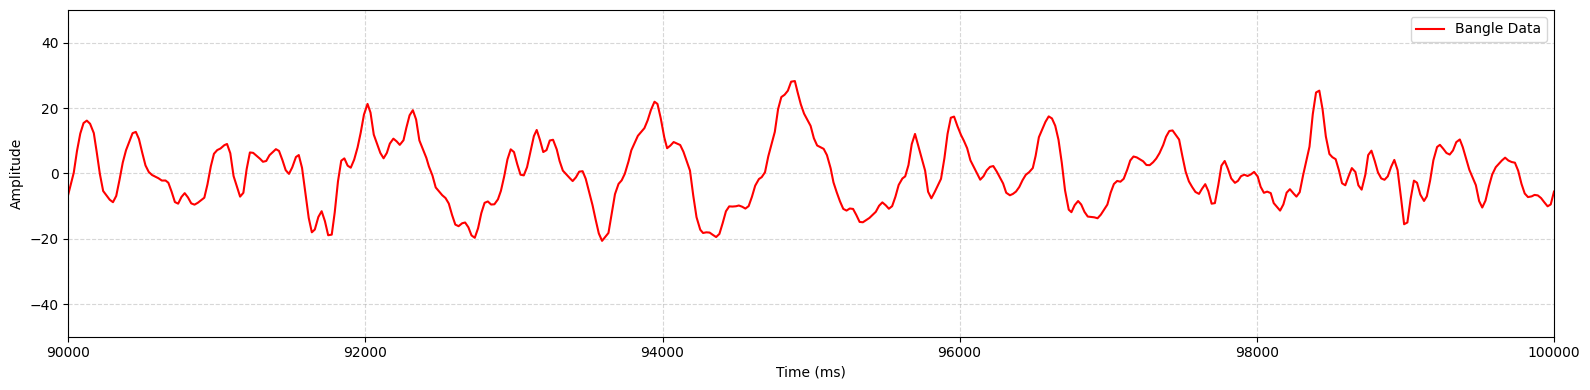

In [22]:
dt = np.diff(timestamps) / 1000.0
fs = 1 / np.mean(dt)
print(f"Estimated PPG sampling rate: {fs:.1f} Hz")

from scipy.signal import butter

lowcut, highcut = 0.5, 8.0
nyq = 0.5 * fs  # Have to normalize the cutoff frequencies by this nyquist rate
b, a = butter(2, [lowcut/nyq, highcut/nyq], btype='band')

from scipy.signal import filtfilt

ppg_filt = filtfilt(b, a, ppg_raw)

plt.figure(figsize=(16, 4))
plt.plot(timestamps, ppg_filt, c='r', label="Bangle Data")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=90000, right=100000)
plt.ylim(bottom=-50, top=50)
plt.tight_layout()
plt.show()

### Finding Peaks With Old Method

Detected 151 peaks in the Filtered PPG


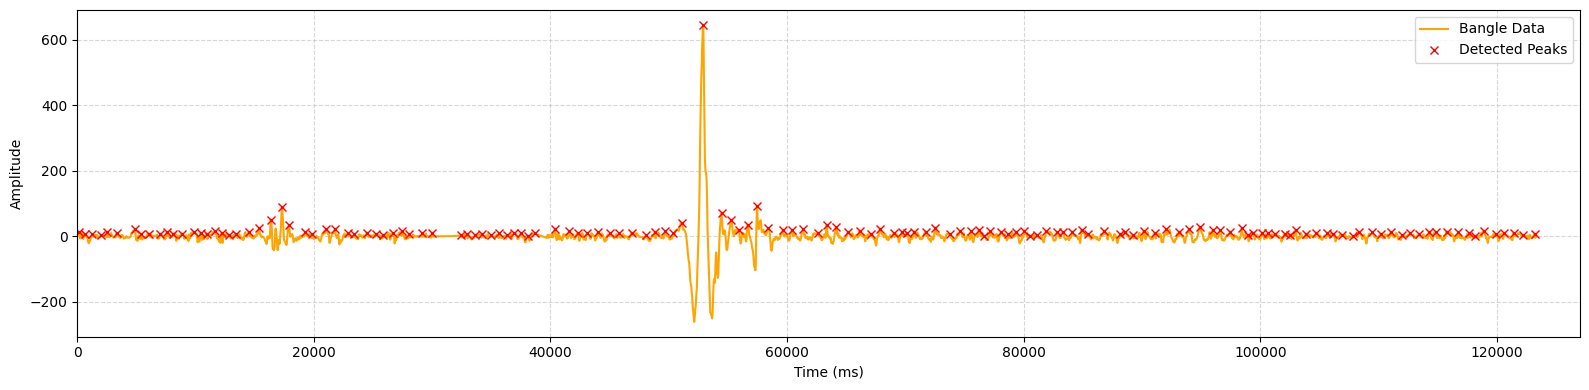

In [23]:
from scipy.signal import find_peaks, find_peaks_cwt

min_dist = int(0.5 * fs)
peaks, props = find_peaks(ppg_filt, distance=min_dist, height=np.mean(ppg_filt))
# peaks = find_peaks_cwt(ppg_filt, widths=min_dist)

print(f"Detected {len(peaks)} peaks in the Filtered PPG")

plt.figure(figsize=(16, 4))
plt.plot(timestamps, ppg_filt, c='orange', label="Bangle Data")
plt.plot(timestamps[peaks], ppg_filt[peaks], 'x', c='red', label="Detected Peaks")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=0, right=127000)
plt.tight_layout()
plt.show()

### New Method with SQA

Initial peaks: 84 → quality-filtered: 81


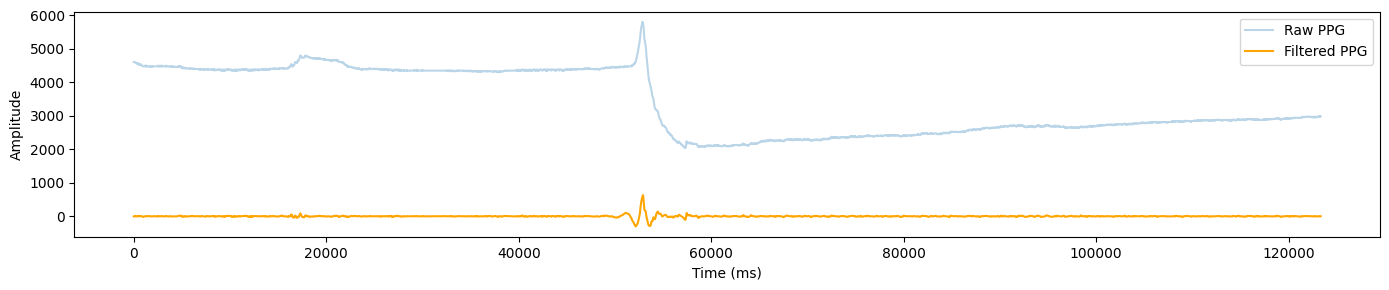

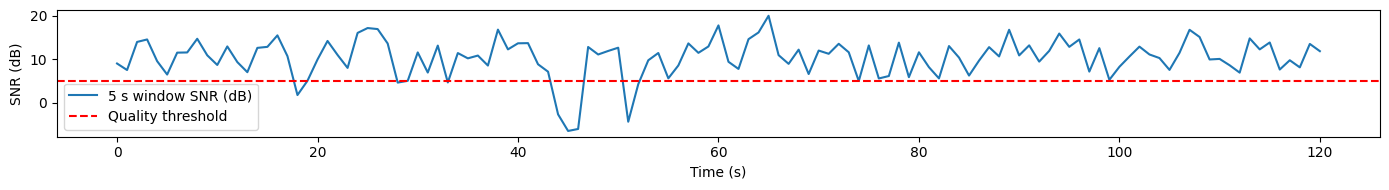

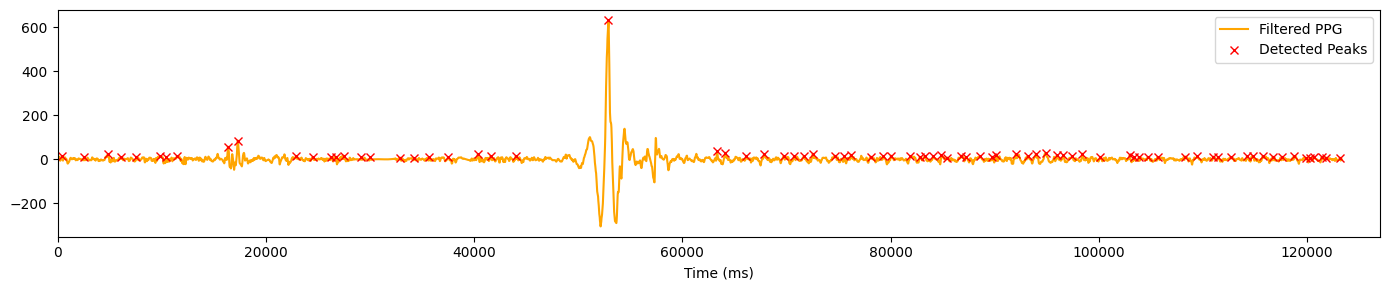

In [24]:
# ─────────── Band-pass PPG (0.5–8 Hz) ───────────
from scipy.signal import butter, filtfilt

lowcut, highcut = 0.5, 8.0

# 4th-order Butterworth bandpass
b, a = butter(
    4,
    [lowcut/(fs/2), highcut/(fs/2)],
    btype='band'
)
ppg_filt = filtfilt(b, a, ppg_raw)

# quick plot to confirm
plt.figure(figsize=(14,3))
plt.plot(timestamps, ppg_raw,   alpha=0.3, label='Raw PPG')
plt.plot(timestamps, ppg_filt, c='orange', label='Filtered PPG')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()

# ─────────── Signal Quality (5 s SNR) ───────────

def compute_snr(ppg, b, a, fs, frame_sec=5, hop_sec=1):
    """Return array of SNR values (in dB) for each 5 s frame."""
    frame_len = int(frame_sec * fs)
    hop_len   = int(hop_sec   * fs)
    snrs = []
    for start in range(0, len(ppg) - frame_len, hop_len):
        seg = ppg[start:start+frame_len]
        inband  = filtfilt(b, a, seg)
        e_in    = np.sum(inband**2)
        e_out   = np.sum((seg - inband)**2)
        snrs.append(10*np.log10(e_in/e_out))
    return np.array(snrs)

snr_vals = compute_snr(ppg_filt, b, a, fs)
# boolean mask of “good” 5 s windows
good_win = snr_vals > 5.0  

# plot SNR over time
times_win = np.arange(len(snr_vals)) * 1.0  # in seconds (1 s hop)
plt.figure(figsize=(14,2))
plt.plot(times_win, snr_vals, label='5 s window SNR (dB)')
plt.axhline(5, color='r', linestyle='--', label='Quality threshold')
plt.xlabel('Time (s)')
plt.ylabel('SNR (dB)')
plt.legend()
plt.tight_layout()

# ─────────── Adaptive Peak Detection ───────────
from scipy.signal import find_peaks

# 1) Build a 10 s moving-max envelope (centered)
win_env = int(10 * fs)
envelope = (
    pd.Series(ppg_filt)
      .rolling(win_env, center=True, min_periods=1)
      .max()
      .to_numpy()
)

# 2) Set threshold at 40% of local envelope
threshold = 0.4 * envelope

# 3) Detect peaks ≥0.4 s apart
peaks, props = find_peaks(
    ppg_filt,
    height=threshold,
    distance=int(0.4 * fs)
)

# 4) Map each peak index → 5 s window index (floor of time in s)
times_peaks = peaks / fs
win_idx = np.floor(times_peaks).astype(int)

# Option A: clamp indices to valid range
win_idx = np.minimum(win_idx, len(good_win)-1)

# 5) Filter peaks by window quality
good_peaks = [pk for pk, w in zip(peaks, win_idx) if good_win[w]]

# 6) Plot result
plt.figure(figsize=(14,3))
plt.plot(timestamps, ppg_filt, c='orange', label='Filtered PPG')
plt.plot(timestamps[good_peaks], ppg_filt[good_peaks],
         'x', c='red', label='Detected Peaks')
plt.xlabel('Time (ms)'); plt.legend(); plt.tight_layout()
plt.xlim(left=0, right=127000)
plt.tight_layout()
print(f"Initial peaks: {len(peaks)} → quality-filtered: {len(good_peaks)}")